In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocess as mp
import glob
import time
from tqdm import tqdm
import os
import sys
import pandas as pd
from eumap.misc import find_files
from eumap.raster import read_rasters, save_rasters
from eumap.mapper import SpaceOverlay
import geopandas as gpd
from pathlib import Path
import rasterio
import pyproj
from shapely.geometry import Point
from eumap.mapper import LandMapper

import warnings

import matplotlib
import matplotlib.pyplot as plt

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFECV, RFE
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor

import joblib
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

### general overview

In [2]:
data = pd.read_csv('/mnt/primus/xuemeng_tmp_harbour/soc_eu/data/soil.full_harmonized_v1.csv',low_memory=False)

na = data['time'].isna().sum()
print(f'{na} data with no time info')
# data = data.dropna(subset=['time'],how='any')

na = len(data[data['hzn_btm'].isna() | data['hzn_top'].isna()])
print(f'{na} data with no depth info')
# data = data.dropna(subset=['hzn_btm','hzn_top'],how='any')

na = len(data[data['lat'].isna() | data['lon'].isna()])
print(f'{na} data with no coordinate info')
data = data.dropna(subset=['lat','lon'],how='any')
print()
print(f'left {len(data)} in total \nafter dropping data without coordinate info')
print()

data['depth'] = data.apply(lambda x: np.mean([x['hzn_top'], x['hzn_btm']]), axis=1)
data['src'] = data['ref'].apply(lambda x: x.split('-')[0])
for nuts0 in data['src'].unique().tolist():
    num = len(data.loc[data['src']==nuts0])
    print(f'{nuts0}:{num}')

0 data with no time info
0 data with no depth info
0 data with no coordinate info

left 101539 in total 
after dropping data without coordinate info

germany.thuenen:17189
croatia.multione:1553
estonia.kese:3015
gemas:4131
slovenia:225
LUCAS:75426


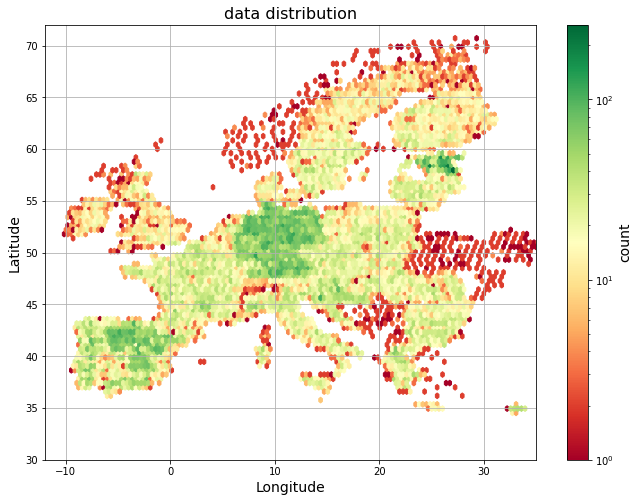

In [13]:
import matplotlib.colors as mcolors
fig, ax = plt.subplots(figsize=(11, 8))
hexbin = ax.hexbin(data['lon'], data['lat'], gridsize=150, cmap='RdYlGn', mincnt=1, norm=mcolors.LogNorm())
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.set_title(f'data distribution', fontsize=16)

ax.set_ylim([30,72])
ax.set_xlim([-12,35])
colorbar = plt.colorbar(hexbin)
colorbar.set_label(f'count', fontsize=14)

plt.grid(True)
plt.show()

Text(0, 0.5, 'year')

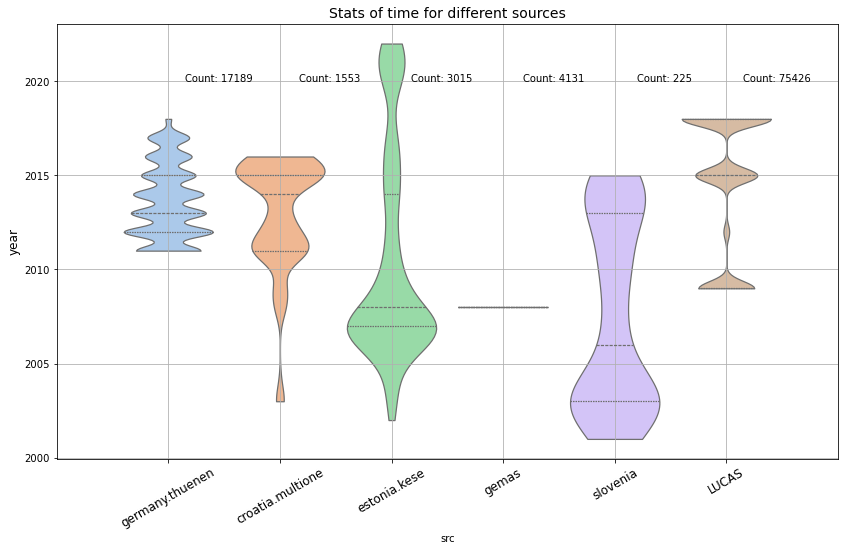

In [21]:
df = data
df = df.dropna(subset=['time'])
df = df.loc[df['time']>=1900].reset_index(drop=True)
time_stats = df.groupby('src')['time'].describe()

positions = range(len(time_stats))
plt.figure(figsize=(14, 8))
sns.violinplot(data=df, x="src", y="time", inner="quartile", cut=0, palette="pastel")
    
order = df['src'].unique()

for i, (index, row) in enumerate(time_stats.iterrows()):
    pos = list(order).index(index)
    # plt.text(pos + 0.45, 340, f"{row['min']:.2f}-{row['max']:.2f}", ha='center', color='black', fontsize=10)
    # plt.text(pos + 0.45, 1945, f"Std: {row['std']:.2f}", ha='center', color='black', fontsize=10)
    plt.text(pos + 0.45, 2020, f"Count: {row['count']:.0f}", ha='center', color='black', fontsize=10)
    
plt.xlim(-1,len(order))
plt.grid()
plt.xticks(rotation=30,fontsize=12)  # Rotate x-axis ticks by 45 degrees
plt.title("Stats of time for different sources",fontsize=14)
plt.ylabel('year',fontsize=12)

Text(0, 0.5, 'Depth below the surface (cm)')

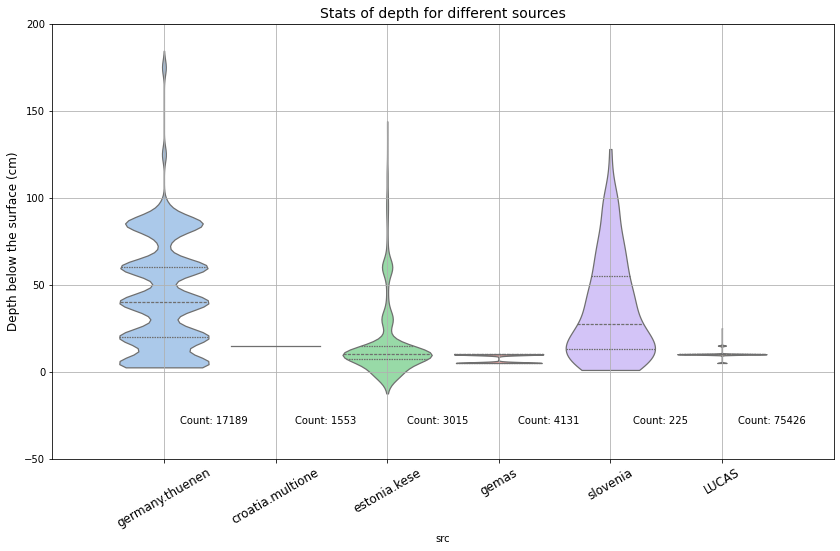

In [15]:
df = data
df = df.dropna(subset=['depth'])
# df = df.loc[df['time']>=1900].reset_index(drop=True)
depth_stats = df.groupby('src')['depth'].describe()

positions = range(len(depth_stats))
plt.figure(figsize=(14, 8))
sns.violinplot(data=df, x="src", y="depth", inner="quartile", cut=0, palette="pastel")
    
order = df['src'].unique()

for i, (index, row) in enumerate(depth_stats.iterrows()):
    pos = list(order).index(index)
    # plt.text(pos + 0.45, 340, f"{row['min']:.2f}-{row['max']:.2f}", ha='center', color='black', fontsize=10)
    # plt.text(pos + 0.45, 240, f"Std: {row['std']:.2f}", ha='center', color='black', fontsize=10)
    plt.text(pos + 0.45, -30, f"Count: {row['count']:.0f}", ha='center', color='black', fontsize=10)
    
plt.xlim(-1,len(order))
plt.ylim(-50,200)
plt.grid()
plt.xticks(rotation=30,fontsize=12)  # Rotate x-axis ticks by 45 degrees
plt.title("Stats of depth for different sources",fontsize=14)
plt.ylabel('Depth below the surface (cm)',fontsize=12)

### availibility

In [16]:
cols = ['oc','N','caco3','ph_h2o','ph_cacl2','clay','silt','sand','bulk_density','P','K']
# cols = ['valid','<0','0-20','20-50','50-100','>100']
srcl = data['src'].unique().tolist()
qq = pd.DataFrame(columns=cols)
for srcc in srcl:
    output_line = [] # Start the line with the 'srcc' value
    temp = data.loc[data['src'] == srcc]
    # temp = temp.dropna(subset=['time'])
    # output_line.append(len(temp))
    
    for i in cols:
        tem = len(temp)-temp[i].isna().sum()
        output_line.append(tem)
        
#     tem = temp.loc[temp['time']<=1950]
#     output_line.append(len(tem))
    
#     tem = temp.loc[(temp['time']>1950) & (temp['time']<=1980)]
#     output_line.append(len(tem))
    
#     tem = temp.loc[(temp['time']>1980) & (temp['time']<=2000)]
#     output_line.append(len(tem))
    
#     tem = temp.loc[(temp['time']>2000) & (temp['time']<=2020)]
#     output_line.append(len(tem))
    
#     tem = temp.loc[temp['time']>2020]
#     output_line.append(len(tem))
    
    qq.loc[srcc] = output_line
    print(output_line)  # Print the entire line


[17189, 17185, 0, 17189, 17189, 16708, 16708, 16708, 13400, 0, 0]
[1500, 742, 1185, 741, 0, 1449, 1449, 1449, 740, 0, 1481]
[1661, 1624, 0, 0, 144, 29, 31, 38, 106, 0, 1305]
[4117, 0, 0, 0, 4130, 4130, 4112, 4112, 0, 0, 0]
[225, 225, 0, 12, 199, 225, 225, 225, 0, 0, 225]
[63220, 62941, 55100, 62941, 62941, 26245, 26245, 26245, 18481, 62915, 62941]


In [17]:
qq

,oc,N,caco3,ph_h2o,ph_cacl2,clay,silt,sand,bulk_density,P,K
germany.thuenen,17189,17185,0,17189,17189,16708,16708,16708,13400,0,0
croatia.multione,1500,742,1185,741,0,1449,1449,1449,740,0,1481
estonia.kese,1661,1624,0,0,144,29,31,38,106,0,1305
gemas,4117,0,0,0,4130,4130,4112,4112,0,0,0
slovenia,225,225,0,12,199,225,225,225,0,0,225
LUCAS,63220,62941,55100,62941,62941,26245,26245,26245,18481,62915,62941


### SOC

In [3]:
df = data
num = len(df.loc[df['oc']=='<6'])
print(f'{num} rows with oc = <6')
df = df.drop(df.loc[df['oc']=='<6'].index)

num = len(df.loc[df['oc']=='< LOD'])
print(f'{num} rows with oc = < LOD')
df = df.drop(df.loc[df['oc']=='< LOD'].index)

num = len(df.loc[df['oc']=='<0.0'])
print(f'{num} rows with oc = <0.0')
df = df.drop(df.loc[df['oc']=='<0.0'].index)  

df['oc'] = pd.to_numeric(df['oc'], errors='coerce')
num = df['oc'].isna().sum()
print(f'{num} rows with oc = nan')
df = df.dropna(subset=['oc'])

num = len(df.loc[df['oc']<0])
print(f'{num} rows with oc<0.0')
df = df.drop(df.loc[df['oc']<0].index)

num = len(df.loc[df['oc']>1000])
print(f'{num} rows with oc>1000')
df = df.drop(df.loc[df['oc']>1000].index)

print(f'{len(df)} rows with valid oc left')

df['oc_log'] = np.log1p(df['oc'].values)
oc_stats = df.groupby('src')['oc'].describe()
oc_stats


231 rows with oc = <6
34 rows with oc = < LOD
2 rows with oc = <0.0
13627 rows with oc = nan
15 rows with oc<0.0
25 rows with oc>1000
87605 rows with valid oc left


,count,mean,std,min,25%,50%,75%,max
src,,,,,,,,
LUCAS,62938.0,45.761732,81.713167,0.10,12.700000,20.700000,39.300000,723.900000
croatia.multione,1500.0,24.079396,18.548709,0.00,12.885256,18.409250,28.679977,186.118523
estonia.kese,1636.0,82.604070,152.249276,0.03,2.602500,13.341067,46.000000,580.000000
gemas,4117.0,32.850425,47.654122,4.00,14.000000,21.000000,34.000000,490.000000
germany.thuenen,17189.0,22.210774,65.579374,0.08,2.420000,7.210000,15.900000,582.890000
slovenia,225.0,68.478222,104.154018,0.00,11.700000,32.500000,83.200000,872.300000


Text(0, 0.5, 'SOC (g/kg)')

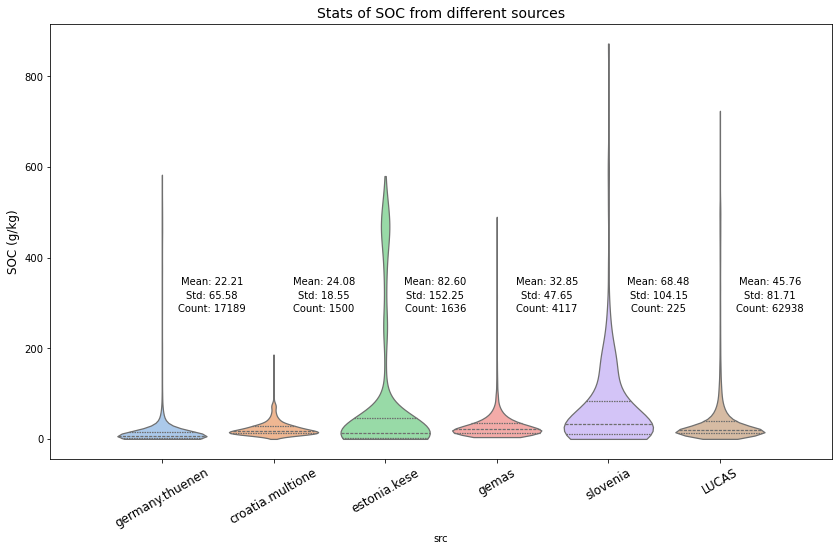

In [5]:


# df = df.loc[df['oc']<1000]
positions = range(len(oc_stats))
plt.figure(figsize=(14, 8))
sns.violinplot(data=df, x="src", y="oc", inner="quartile", cut=0, palette="pastel")
    
order = df['src'].unique()

for i, (index, row) in enumerate(oc_stats.iterrows()):
    pos = list(order).index(index)
    plt.text(pos + 0.45, 340, f"Mean: {row['mean']:.2f}", ha='center', color='black', fontsize=10)
    plt.text(pos + 0.45, 310, f"Std: {row['std']:.2f}", ha='center', color='black', fontsize=10)
    plt.text(pos + 0.45, 280, f"Count: {row['count']:.0f}", ha='center', color='black', fontsize=10)
    
plt.xlim(-1,len(order))
plt.xticks(rotation=30,fontsize=12)  # Rotate x-axis ticks by 45 degrees
plt.title("Stats of SOC from different sources",fontsize=14)
plt.ylabel('SOC (g/kg)',fontsize=12)


### pH H2O

In [6]:
df = data

df['ph_h2o'] = pd.to_numeric(df['ph_h2o'], errors='coerce')
num = df['ph_h2o'].isna().sum()
print(f'{num} rows with nan ph_h2o')
df = df.dropna(subset=['ph_h2o'])

num = len(df.loc[df['ph_h2o']<0])
print(f'{num} rows with ph_h2o<0.0')
df = df.drop(df.loc[df['ph_h2o']<0].index)

print(f'{len(df)} rows with valid ph_h2o left')

ph_h2o_stats = df.groupby('src')['ph_h2o'].describe()
ph_h2o_stats

20656 rows with nan ph_h2o
2 rows with ph_h2o<0.0
80881 rows with valid ph_h2o left


,count,mean,std,min,25%,50%,75%,max
src,,,,,,,,
LUCAS,62939.0,6.209331,1.331507,3.170000,5.050,6.21,7.480000,10.430000
croatia.multione,741.0,6.428699,1.153263,4.193333,5.450,6.37,7.633333,8.226667
germany.thuenen,17189.0,6.576164,0.959851,2.800000,5.880,6.55,7.310000,9.220000
slovenia,12.0,8.091667,0.144338,7.900000,7.975,8.15,8.200000,8.300000


Text(0, 0.5, 'pH_H2O')

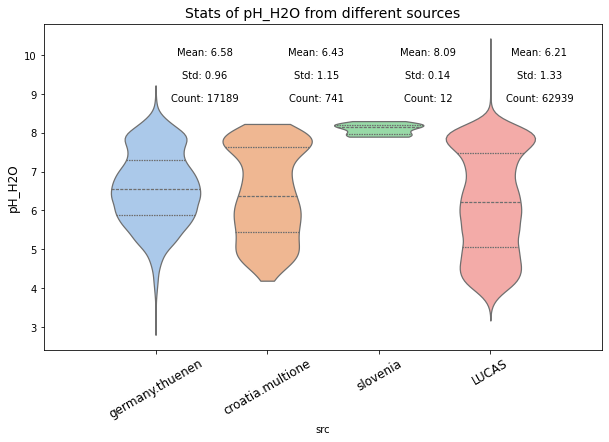

In [8]:
ph_h2o_stats = df.groupby('src')['ph_h2o'].describe()
positions = range(len(ph_h2o_stats))
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x="src", y="ph_h2o", inner="quartile", cut=0, palette="pastel")
    
order = df['src'].unique()

for i, (index, row) in enumerate(ph_h2o_stats.iterrows()):
    pos = list(order).index(index)
    plt.text(pos + 0.44, 10, f"Mean: {row['mean']:.2f}", ha='center', color='black', fontsize=10)
    plt.text(pos + 0.44, 9.4, f"Std: {row['std']:.2f}", ha='center', color='black', fontsize=10)
    plt.text(pos + 0.44, 8.8, f"Count: {row['count']:.0f}", ha='center', color='black', fontsize=10)
    
plt.xlim(-1,len(order))
plt.xticks(rotation=30,fontsize=12)  # Rotate x-axis ticks by 45 degrees
plt.title("Stats of pH_H2O from different sources",fontsize=14)
plt.ylabel('pH_H2O',fontsize=12)


### pH_KCl

In [30]:
df = data

df['ph_kcl'] = pd.to_numeric(df['ph_kcl'], errors='coerce')
num = df['ph_kcl'].isna().sum()
print(f'{num} rows with nan ph_kcl')
df = df.dropna(subset=['ph_kcl'])

num = len(df.loc[df['ph_kcl']<0])
print(f'{num} rows with ph_kcl<0.0')
df = df.drop(df.loc[df['ph_kcl']<0].index)

print(f'{len(df)} rows with valid ph_kcl left')

ph_kcl_stats = df.groupby('src')['ph_kcl'].describe()
ph_kcl_stats


138306 rows with nan ph_kcl
3 rows with ph_kcl<0.0
43442 rows with valid ph_kcl left


,count,mean,std,min,25%,50%,75%,max
src,,,,,,,,
croatia.multione,2116.0,5.782184,1.244794,1.590909,4.74587,6.0,6.90,8.1
estonia.kese,78.0,5.910256,0.705928,5.000000,5.00000,6.0,6.00,7.0
vlaanderen.belgium,41248.0,5.285191,1.199035,0.000000,4.30000,5.1,6.15,13.8


Text(0, 0.5, 'ph_kcl')

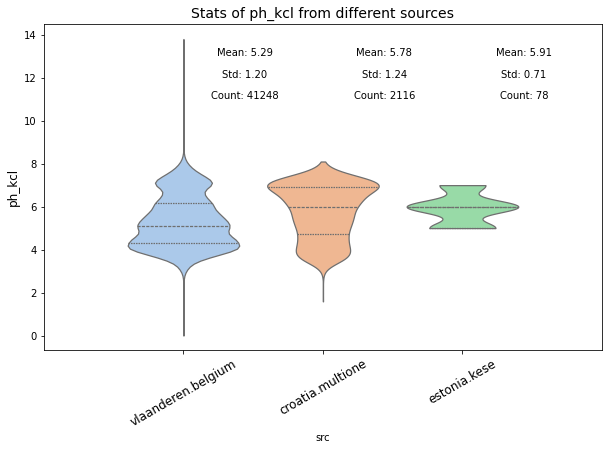

In [35]:
ph_kcl_stats = df.groupby('src')['ph_kcl'].describe()
positions = range(len(ph_kcl_stats))
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x="src", y="ph_kcl", inner="quartile", cut=0, palette="pastel")
    
order = df['src'].unique()

for i, (index, row) in enumerate(ph_kcl_stats.iterrows()):
    pos = list(order).index(index)
    plt.text(pos + 0.44, 13, f"Mean: {row['mean']:.2f}", ha='center', color='black', fontsize=10)
    plt.text(pos + 0.44, 12, f"Std: {row['std']:.2f}", ha='center', color='black', fontsize=10)
    plt.text(pos + 0.44, 11, f"Count: {row['count']:.0f}", ha='center', color='black', fontsize=10)
    
plt.xlim(-1,len(order))
# plt.ylim(-10,30)
plt.xticks(rotation=30,fontsize=12)  # Rotate x-axis ticks by 45 degrees
plt.title("Stats of ph_kcl from different sources",fontsize=14)
plt.ylabel('ph_kcl',fontsize=12)

### ph_cacl2

In [36]:
df = data

df['ph_cacl2'] = pd.to_numeric(df['ph_cacl2'], errors='coerce')
num = df['ph_cacl2'].isna().sum()
print(f'{num} rows with nan ph_cacl2')
df = df.dropna(subset=['ph_cacl2'])

num = len(df.loc[df['ph_cacl2']<0])
print(f'{num} rows with ph_cacl2<0.0')
df = df.drop(df.loc[df['ph_cacl2']<0].index)

print(f'{len(df)} rows with valid ph_cacl2 left')

ph_cacl2_stats = df.groupby('src')['ph_cacl2'].describe()
ph_cacl2_stats


68103 rows with nan ph_cacl2
2 rows with ph_cacl2<0.0
113646 rows with valid ph_cacl2 left


,count,mean,std,min,25%,50%,75%,max
src,,,,,,,,
LUCAS,62939.0,5.702284,1.398085,2.57,4.50,5.78,7.10,10.00
estonia.kese,66.0,4.651515,1.270886,3.00,4.00,4.00,5.75,7.00
gemas,4130.0,5.782024,1.137789,3.26,4.81,5.62,6.97,8.06
germany.thuenen,17189.0,5.981606,1.041687,2.48,5.20,5.98,6.83,8.11
ireland.tellus,26713.0,4.750381,0.980608,0.00,4.10,4.80,5.40,7.78
scotland.NSIS1,2609.0,4.183089,0.906031,2.31,3.42,4.10,4.77,7.74


Text(0, 0.5, 'ph_cacl2')

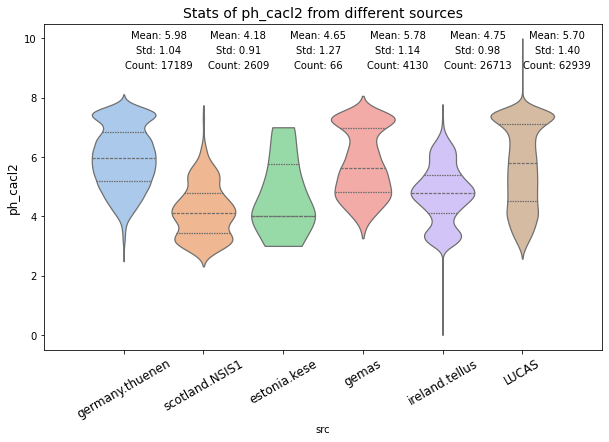

In [42]:
ph_cacl2_stats = df.groupby('src')['ph_cacl2'].describe()
positions = range(len(ph_cacl2_stats))
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x="src", y="ph_cacl2", inner="quartile", cut=0, palette="pastel")
    
order = df['src'].unique()

for i, (index, row) in enumerate(ph_cacl2_stats.iterrows()):
    pos = list(order).index(index)
    plt.text(pos + 0.44, 10, f"Mean: {row['mean']:.2f}", ha='center', color='black', fontsize=10)
    plt.text(pos + 0.44, 9.5, f"Std: {row['std']:.2f}", ha='center', color='black', fontsize=10)
    plt.text(pos + 0.44, 9, f"Count: {row['count']:.0f}", ha='center', color='black', fontsize=10)
    
plt.xlim(-1,len(order))
# plt.ylim(-10,100)
plt.xticks(rotation=30,fontsize=12)  # Rotate x-axis ticks by 45 degrees
plt.title("Stats of ph_cacl2 from different sources",fontsize=14)
plt.ylabel('ph_cacl2',fontsize=12)

### N

In [6]:
df = data

df['N'] = pd.to_numeric(df['N'], errors='coerce')
num = df['N'].isna().sum()
print(f'{num} rows with nan N')
df = df.dropna(subset=['N'])

num = len(df.loc[df['N']<0])
print(f'{num} rows with N<0.0')
df = df.drop(df.loc[df['N']<0].index)

print(f'{len(df)} rows with valid N left')

N_stats = df.groupby('src')['N'].describe()
N_stats

89841 rows with nan N
7 rows with N<0.0
91903 rows with valid N left


,count,mean,std,min,25%,50%,75%,max
src,,,,,,,,
LUCAS,62918.0,8.757355,35.886357,0.00,1.3000,2.00,3.40,1038.0
croatia.multione,5260.0,2.740320,2.101439,0.00,1.3900,2.12,3.40,18.8
estonia.kese,170.0,15.047059,7.307945,1.00,12.0000,16.00,19.00,35.0
france.RMQS,4143.0,2.015184,2.599882,0.02,0.7425,1.23,2.17,21.1
germany.thuenen,17185.0,1.542623,3.237376,0.01,0.2900,0.72,1.46,32.7
scotland.NSIS1,2227.0,8.720162,9.491487,0.00,1.1000,3.80,16.00,46.8


Text(0, 0.5, 'N')

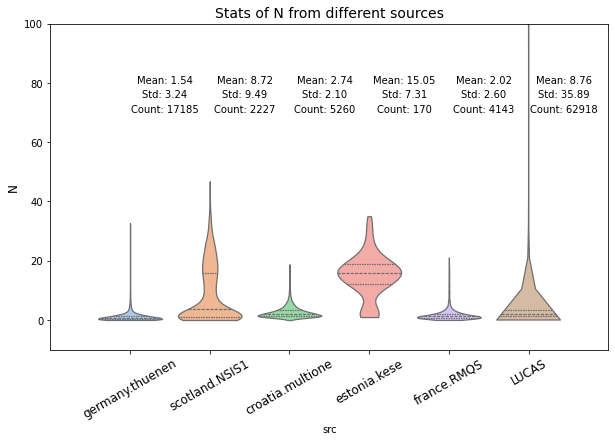

In [11]:
N_stats = df.groupby('src')['N'].describe()
positions = range(len(N_stats))
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x="src", y="N", inner="quartile", cut=0, palette="pastel")
    
order = df['src'].unique()

for i, (index, row) in enumerate(N_stats.iterrows()):
    pos = list(order).index(index)
    plt.text(pos + 0.44, 80, f"Mean: {row['mean']:.2f}", ha='center', color='black', fontsize=10)
    plt.text(pos + 0.44, 75, f"Std: {row['std']:.2f}", ha='center', color='black', fontsize=10)
    plt.text(pos + 0.44, 70, f"Count: {row['count']:.0f}", ha='center', color='black', fontsize=10)
    
plt.xlim(-1,len(order))
plt.ylim(-10,100)
plt.xticks(rotation=30,fontsize=12)  # Rotate x-axis ticks by 45 degrees
plt.title("Stats of N from different sources",fontsize=14)
plt.ylabel('N',fontsize=12)

### CaCO3

In [27]:
df = data

df['caco3'] = pd.to_numeric(df['caco3'], errors='coerce')
num = df['caco3'].isna().sum()
print(f'{num} rows with nan caco3')
df = df.dropna(subset=['caco3'])

num = len(df.loc[df['caco3']<0])
print(f'{num} rows with caco3<0.0')
df = df.drop(df.loc[df['caco3']<0].index)

num = len(df.loc[df['caco3']>=1000])
print(f'{num} rows with caco3>=1000')
df = df.drop(df.loc[df['caco3']>=1000].index)

print(f'{len(df)} rows with valid caco3 left')

caco3_stats = df.groupby('src')['caco3'].describe()
caco3_stats

79039 rows with nan caco3
8 rows with caco3<0.0
2 rows with caco3>=1000
102702 rows with valid caco3 left


,count,mean,std,min,25%,50%,75%,max
src,,,,,,,,
LUCAS,54403.0,62.666976,138.547435,0.0,0.0,1.0,31.0,976.000000
croatia.multione,2757.0,74.338902,135.980759,0.0,0.0,8.4,80.3,696.666667
estonia.kese,85.0,10.894118,4.094199,2.0,10.0,10.0,10.0,35.000000
france.RMQS,4143.0,55.662925,141.738612,0.5,0.5,0.5,7.0,915.000000
vlaanderen.belgium,41314.0,16.140347,50.473695,0.0,0.0,0.0,0.0,999.000000


Text(0, 0.5, 'caco3')

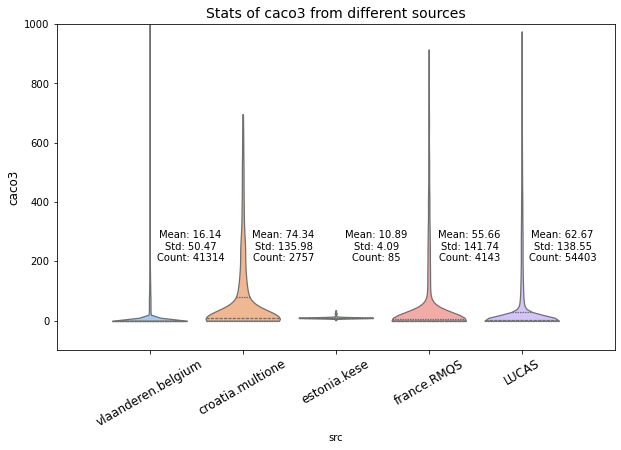

In [28]:
caco3_stats = df.groupby('src')['caco3'].describe()
positions = range(len(caco3_stats))
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x="src", y="caco3", inner="quartile", cut=0, palette="pastel")
    
order = df['src'].unique()

for i, (index, row) in enumerate(caco3_stats.iterrows()):
    pos = list(order).index(index)
    plt.text(pos + 0.44, 280, f"Mean: {row['mean']:.2f}", ha='center', color='black', fontsize=10)
    plt.text(pos + 0.44, 240, f"Std: {row['std']:.2f}", ha='center', color='black', fontsize=10)
    plt.text(pos + 0.44, 200, f"Count: {row['count']:.0f}", ha='center', color='black', fontsize=10)
    
plt.xlim(-1,len(order))
plt.ylim(-100,1000)
plt.xticks(rotation=30,fontsize=12)  # Rotate x-axis ticks by 45 degrees
plt.title("Stats of caco3 from different sources",fontsize=14)
plt.ylabel('caco3',fontsize=12)

In [9]:
grouped = df.groupby('country').size().reset_index(name='count').sort_values(by='count',ascending=False)
group = grouped.loc[grouped['count']>2500]['country'].values.tolist()
group.remove('belgium')

df['group_id'] = df['country']
df['group_id'] = df.apply(lambda x: x['country']+'_'+str(int(x['gps_long']*4))+','+str(int(x['gps_lat']*4)) if x['country']=='belgium' else x['group_id'],axis=1)
df['group_id'] = df.apply(lambda x: x['country']+'_'+str(int(x['gps_long']))+','+str(int(x['gps_lat'])) if x['country'] in group else x['group_id'],axis=1)
# grouped = dff.groupby('coor_index').size().reset_index(name='Count').sort_values(by='Count',ascending=False)
# grouped.head(20)
groupt = df.groupby('group_id').size().reset_index(name='count').sort_values(by='count',ascending=False)
print(f'{len(groupt)} groups')


696 groups


In [10]:
# merge (very small size) possible classes
ldf = groupt.loc[groupt['count']<80]['group_id'].values.tolist()
df['group_id'] = df.apply(lambda x: x['group_id'].split('_')[0] if x['group_id'] in ldf else x['group_id'],axis=1)
groupt = df.groupby('group_id').size().reset_index(name='count').sort_values(by='count',ascending=False)
print(f'{len(groupt)} groups')


383 groups
